In [5]:
# Beam bending processing

import math, collections, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats

# Global utilities
ureg    = pint_pandas.PintType.ureg
dtime_t = pd.to_timedelta(1, unit='s')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_csv_mec(path, pint=True):
    '''Import Mecmesin data'''
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

def pint2dtime(times):
    '''Converts Pint time values to Pandas deltatime.'''
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        # Strip "pint[...]" text wrapping the unit string.
        unit = str(times.dtype)[5:-1]
    )

def event_times(event_coding):
    '''Extracts event start times from Mecmesin event coding.'''
    return event_coding[event_coding.diff() == -1].index

def time2state(times, events):
    '''
    Labels each time with an associated state based on Mecmesin event start times.
    I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
    '''
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

# User inputs
data = [
    dotdict(
        data      = 'data_bending/00 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = 'data_bending/01 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = 'data_bending/02 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = 'data_bending/03 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = 'data_bending/04 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
    dotdict(
        data      = 'data_bending/05 beam fixed center CF L=20mm w=100um t=129um.csv',
        length    =  20 * ureg.mm,
        width     = 100 * ureg.um,
        thickness = 129 * ureg.um,
    ),
]

for dat in data:
    # Preprocess
    dat.df       = read_csv_mec(dat.data)
    dat.df.index = pint2dtime(dat.df.Time)
    dat.events   = event_times(dat.df.Event)
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)
    dat.df.dropna(inplace=True)
    
    # Append flexural modulus estimate
    # dat.df['FlexMod'] = ((1/16) * (dat.df.Force / dat.df.Distance) * (dat.length**3 / dat.width / dat.thickness**3)).pint.to(ureg.GPa)

    # Create Pint-unitless data copy to suppress errors when plotting.
    # Remove unit headers from dequantify(). These cause errors with column access.
    dat.dfdq = dat.df.pint.dequantify()
    dat.dfdq.columns = dat.dfdq.columns.droplevel(-1)

# Returns Standard Error of the Mean (SEM): std / sqrt(n)
def sem(n, sum1, sum2):
    return np.sqrt((sum2 - sum1*sum1/n) / (n-1)) / np.sqrt(n)

# Checks if all elements in series are equivalent
def varies(s):
    return not (s == s.iloc[0]).all()

# Returns plottable line segment
def region_line(x0, x1, slope, intercept):
    f = lambda x: x * slope + intercept
    return [x0, x1], [f(x0), f(x1)]

# Linearization result datastructure
Region = collections.namedtuple('Region', 'i x0 x1 dx soln')

# Converges on the largest linear span in a curve with least-squares regression and quasi-Monte Carlo sampling.
# Statistical modification of https://doi.org/10.1063/1.4969058
# Standard Error of the Mean (SEM) stopping rule: https://www.maxvalue.com/tip025.htm
def large_linear_region(df, r2_limit, sem_goal, qmc_kernel=stats.qmc.LatinHypercube(1)):
    assert len(df.columns) == 2
    x_unique = np.unique(df[df.columns[0]])
    n_unique = len(x_unique)
    best_fit = None
    r_sum1, r_sum2 = 0, 0
    for i in itertools.takewhile(lambda i: i < 2 or sem(i, r_sum1, r_sum2) > sem_goal, itertools.count()):
        x0, x1 = sorted(x_unique[[np.int_(qmc_kernel.random(n=2) * n_unique)]][0].squeeze())
        dx = x1 - x0 
        sel = df[(df[df.columns[0]] >= x0) & (df[df.columns[0]] <= x1)]
        if not varies(sel[sel.columns[0]]):
            continue
        soln = stats.linregress(*[v.squeeze() for v in np.hsplit(sel.values, 2)])
        r_sum1 += soln.rvalue
        r_sum2 += (r2 := soln.rvalue*soln.rvalue)
        if r2 >= r2_limit and (not best_fit or dx > best_fit.dx):
            best_fit = Region(i, x0, x1, dx, soln)
    return best_fit

def find_linear_regions(df, max_depth, **kwargs):
    if max_depth == 0 or len(df) <= 2 or not varies(df[df.columns[0]]):
        return []
    for _ in range(max_depth):
        if lin := large_linear_region(df, **kwargs):
            break
    if lin:
        return find_linear_regions(df[df[df.columns[0]] <= lin.x0], max_depth-1, **kwargs) + [lin] + find_linear_regions(df[df[df.columns[0]] >= lin.x1], max_depth-1, **kwargs)
    return []

def linearize_region(df):
    soln = stats.linregress(*[v.squeeze() for v in np.hsplit(df.values, 2)])
    x0, x1 = df[df.columns[0]].min(), df[df.columns[0]].max()
    return Region(0, x0, x1, x1-x0, soln)

# Find relevant linear regions
solns = []
for dat in data:
    for i in range(dat.df.Cycle.max()+1):
        for j in range(dat.df.Loading.max()+1):
            result = linearize_region(dat.dfdq[(dat.df.Cycle==i) & (dat.df.Loading==j) & (dat.df.Distance<= 200*ureg.um)][['Distance', 'Force']]) # Opinionated force range: [0.0, 0.2 N])
            solns.append(result)
            # Run QMC instead:
            # while True:
            #     if len(result := find_linear_regions(
            #         dat.dfdq[(dat.df.Cycle==i) & (dat.df.Loading==j) & (dat.df.Distance<= 200 * ureg.um)][['Distance', 'Force']], # Opinionated force range: [0.1, 0.2 N]
            #         max_depth=1,
            #         r2_limit=0.8,
            #         sem_goal=0.01
            #     )) > 0: # Opinionated requirement
            #         solns.append(result[-1]) # Get slope of last line, which for these data most represents the model
            #         print(result[-1])
            #         break
            # print(result)
# print(f'Number of successful runs: {len(solns)} (100 %)')

data_bending = data

In [6]:
# Plot beam bending
def plot_bending(ax, data):
    # Process solutions
    x_t, y_t = ureg.parse_expression(str(data[0].df.dtypes.iloc[1])[5:-1]), ureg.parse_expression(str(data[0].df.dtypes.iloc[0])[5:-1])
    X0, X1, slopes, icepts, R2 = zip(*[(soln.x0, soln.x1, soln.soln.slope, soln.soln.intercept, soln.soln.rvalue**2) for soln in solns])
    x0_mu, x1_mu, slope_mu, slope_se, icept_mu, icept_se, r2_mu = np.mean(X0), np.mean(X1), np.mean(slopes), np.std(slopes), np.mean(icepts), np.std(icepts), np.mean(R2)
    
    # Get flexural modulus
    slope = np.array([slope_mu, slope_se]) * y_t / x_t
    const = (1/16) * (20*ureg.mm)**3 / ((100*ureg.um) * (129*ureg.um)**3)
    E = (slope * const).to(ureg.GPa)
    print(E)
    
    # Plot settings
    mpl.rcParams['font.size']        = 14
    mpl.rcParams['font.family']      = 'STIXGeneral'
    mpl.rcParams['mathtext.fontset'] = 'stix'
    
    # Setup plot
    # plt.subplots_adjust(hspace = 0.375)
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # Plot data
    for dat in data:
        dat.dfdq.plot.scatter('Distance', 'Force', s=0.001, c='darkgrey', ax=ax)
    ax.plot(*region_line(x0_mu, x1_mu, slope_mu, icept_mu), c='#d62728')
    ax.fill_between([x0_mu, x1_mu], region_line(x0_mu, x1_mu, slope_mu-slope_se, icept_mu-icept_se)[1], region_line(x0_mu, x1_mu, slope_mu+slope_se, icept_mu+icept_se)[1], facecolor='#d62728', alpha=0.3)
    ax.text(
        0.02,
        0.97,
        f'n = {len(solns)}\n'
        r'$r^2 = $' + '%.5f' % round(r2_mu, 5) + '\n'
        r'$F / \delta = $' + '%.4f' % round(slope_mu * 1000, 4) + ' ± ' + '%.4f' % round(slope_se * 1000, 4) + f' ({format(ureg.newton/ureg.meter, "~")})\n'
        r'⇒ $E_{flex} = $' + '%.3f' % round(E[0].m, 3) + ' ± ' + '%.4f' % round(E[1].m, 4) + f' ({format(E[0].u, "~")})\n',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
    )
    ax.set_xlabel(f'{ax.xaxis.get_label().get_text()} ({format(x_t.u, "~")})')
    ax.set_ylabel(f'{ax.yaxis.get_label().get_text()} ({format(y_t.u, "~")})')
    # ax.set_aspect(1/2)
    
    # Plot inset; plot commands are copied from above
    axins = ax.inset_axes([0.7, 0.18, 0.27, 0.4], xlim=[0, 0.23], ylim=[-0.01, 0.03])
    for dat in data:
        dat.dfdq.plot.scatter('Distance', 'Force', s=0.001, c='darkgrey', ax=axins)
    axins.plot(*region_line(x0_mu, x1_mu, slope_mu, icept_mu), c='#d62728')
    axins.fill_between([x0_mu, x1_mu], region_line(x0_mu, x1_mu, slope_mu-slope_se, icept_mu-icept_se)[1], region_line(x0_mu, x1_mu, slope_mu+slope_se, icept_mu+icept_se)[1], facecolor='#d62728', alpha=0.3)
    axins.set_xlabel('')
    axins.set_ylabel('')
    ax.indicate_inset_zoom(axins, edgecolor="black")

    return ax

In [155]:
# Plot roughness
from adjustText import adjust_text
from scipy import interpolate

def plot_roughness(ax):
    df = pd.DataFrame(columns=['Power', 'ASH', 'RA'], data=[
        [00.00, 00.00, 04.76],
        [00.30, 05.43, 06.45],
        [00.40, 06.75, 11.16],
        [00.50, 19.43, 08.20],
        [01.00, 16.53, 13.73],
        [01.50, 31.65, 16.19],
        [02.00, 32.66, 17.41],
    ])

    ax.plot(df.ASH, df.RA, marker='o')

    plt.sca(ax)
    labels = [plt.text(r.ASH, r.RA, f'{r.Power} W') for _, r in df.iterrows()]
    x = np.linspace(min(df.ASH), max(df.ASH), 20)
    y = interpolate.interp1d(df.ASH, df.RA)(x)
    adjust_text(labels, x=x, y=y, expand=(2,2))

    plt.margins(0.1, 0.1)
    ax.set_xlabel(u'Step Height, \u03bcm')
    ax.set_ylabel(u'Roughness, \u03bcm')

    return ax

In [156]:
# Process contact resistance data
import math, glob, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dtime_t = pd.to_timedelta(1, unit='s')

data_glob_path  = 'data/dmm.*.csv'
plot_start_time = pd.to_timedelta(1, unit='s')
power_map = {
     0 : '0 W',
     1 : '0.5 W',
     2 : '0.5 W',
     3 : '0.5 W',
     4 : '1 W',
     5 : '1 W',
     6 : '1 W',
     7 : '1.5 W',
     8 : '1.5 W',
     9 : '1.5 W',
    10 : '0 W',
}

df = pd.concat([pd.read_csv(f, header=[0], skiprows=[1], index_col=[0]).assign(Sample=int(f.split('.')[1])) for f in glob.iglob(data_glob_path)], ignore_index=True)

df.index          = pd.to_timedelta(df.Time, unit='s')
df['Power']       = df.Sample.apply(lambda n : power_map[n % 11])
df['Copy']        = df.Sample.apply(lambda n : '#2' if (n // 11) % 2 else '#1')
df['Face']        = df.Sample.apply(lambda n : 'Back' if n // 44 else 'Front')
df['Orientation'] = df.Sample.apply(lambda n : 'Perpendicular' if (n // 22) % 2 else 'Parallel')
max_sample_time = max([data.Time.diff().max() for _, data in df.groupby('Sample')]) * dtime_t

data_contact = df

In [157]:
# Plot contact resistance data
def plot_contact(ax, data):
    #TODO
    mpl.rcParams['font.size']        = 14
    mpl.rcParams['font.family']      = 'STIXGeneral'
    mpl.rcParams['mathtext.fontset'] = 'stix'
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=mpl.figure.figaspect(1))
    lines = []
    
    for (title, gf), ax, i in zip(df.groupby(['Face', 'Orientation']), np.flip(axes, 0).reshape(-1), [2, 3, 0, 1]):
        ax.set_title(f'({chr(ord("a") + i)}) {", ".join(title)}')
        for (label, gff), j in zip(gf.groupby('Power'), itertools.count()):
            res    = pd.concat([data.Resistance.resample(max_sample_time).mean() for sample, data in gff.groupby('Sample')], axis=1)
            r_mean = res.mean(axis=1)[res.index >= plot_start_time]
            r_std  = res.std(axis=1)[res.index >= plot_start_time]
    
            plot = ax.plot(r_mean.index / dtime_t, r_mean, color=palette[j], label=label)
            ax.fill_between(r_mean.index / dtime_t, r_mean + r_std, r_mean - r_std, facecolor=palette[j], alpha=0.3)
            if i == 0:
                lines += plot
    
    plt.xticks([1, 10, 20, 30])
    fig.supxlabel('Contact time (s)')
    fig.supylabel('Contact resistance (Ω)', x=-0.01)
    
    # Style legend
    leg = axes[0,0].legend(
        lines,
        [l.get_label() for l in lines],
        loc='upper left',
        fontsize=10,
    )
    for line in leg.get_lines():
        line.set_linewidth(2)

    return ax

[230.7571665513143 41.70080433628001] gigapascal


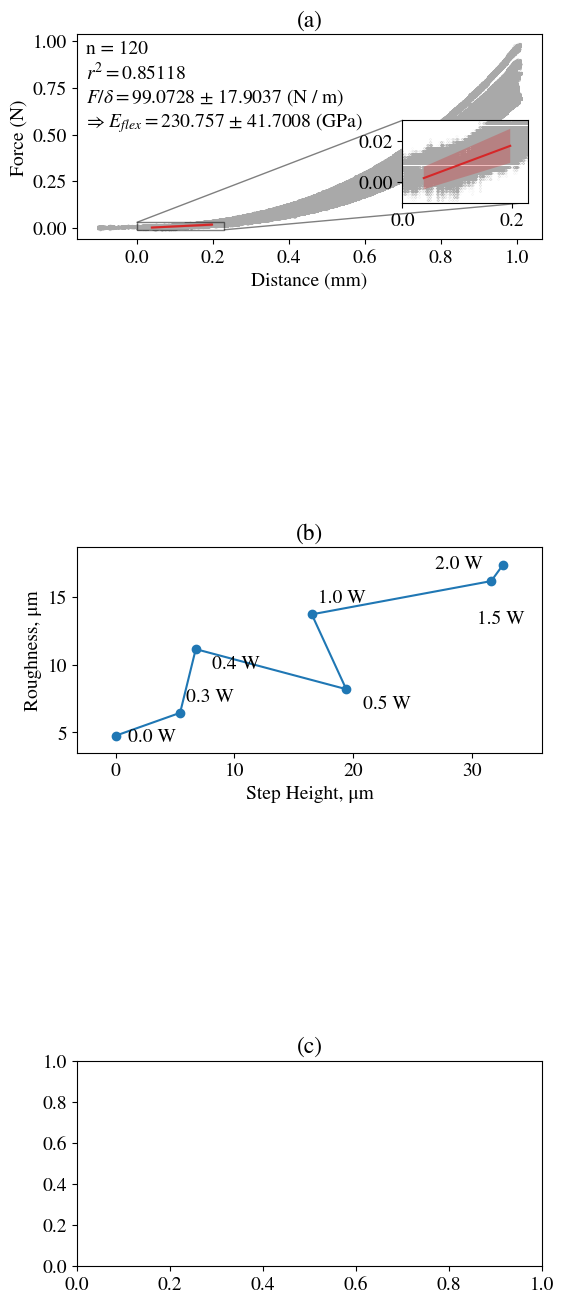

In [161]:
# Plot figure
fig, axs = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)
fig.set_size_inches(6,16)

plot_bending(axs[0], data_bending)
axs[0].set_title('(a)')

plot_roughness(axs[1])
axs[1].set_title('(b)')

plot_contact(axs[2], data_contact)
axs[2].set_title('(c)')

plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()